## IoT Traffic Prediction using RNN Models

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Load the dataset
df = pd.read_csv("../dataset/esp32_1_data.csv")
df.head() # Display the first few rows of the dataset

,timestamp,temperature,humidity(%),latency(ms),throughput(bytes/sec),packet_loss(%),rssi(dBm)
0,2025-05-12 | 10:14:13,28.3,81.5,0.242920,0.054,0.0,-61
1,2025-05-12 | 10:14:15,28.5,80.2,0.336914,0.054,0.0,-61
2,2025-05-12 | 10:14:17,28.5,80.2,0.206543,0.054,0.0,-62
3,2025-05-12 | 10:14:19,28.5,80.2,0.434326,0.054,0.0,-65
4,2025-05-12 | 10:14:21,28.5,80.2,0.428711,0.054,0.0,-55


### Data Preprocessing

In [3]:
# Change the time column to datetime format and split it into date and time
df["timestamp"] = pd.to_datetime(df["timestamp"], format="%Y-%m-%d | %H:%M:%S")

# Set the timestamp as the index
df.set_index("timestamp", inplace=True)
df_resampled = df.resample("min").mean()

# Check the shape of the dataset
print(f"Shape of the dataset: {df_resampled.shape}")

# Check the missing values in the dataset
print(f"Missing values in the dataset:\n{df_resampled.isnull().sum()}")

Shape of the dataset: (1896, 6)
Missing values in the dataset:
temperature              117
humidity(%)              117
latency(ms)              117
throughput(bytes/sec)    117
packet_loss(%)           117
rssi(dBm)                117
dtype: int64


In [4]:
# Impute missing values using mean of the column
df_resampled.fillna(df_resampled.mean(), inplace=True)

# Check the missing values after imputation
print(f"Missing values after imputation:\n{df_resampled.isnull().sum()}")

Missing values after imputation:
temperature              0
humidity(%)              0
latency(ms)              0
throughput(bytes/sec)    0
packet_loss(%)           0
rssi(dBm)                0
dtype: int64


In [5]:
# Show the data in 24 hours from 12:00:00 to 12:00:00
df_one_day_format = df_resampled.loc["2025-05-12 12:00:00":"2025-05-13 12:00:00"]

# Check the data
df_one_day_format.head()

,temperature,humidity(%),latency(ms),throughput(bytes/sec),packet_loss(%),rssi(dBm)
timestamp,,,,,,
2025-05-12 12:00:00,30.909752,74.027475,0.277156,0.054,0.0,-57.561011
2025-05-12 12:01:00,30.909752,74.027475,0.277156,0.054,0.0,-57.561011
2025-05-12 12:02:00,30.909752,74.027475,0.277156,0.054,0.0,-57.561011
2025-05-12 12:03:00,30.909752,74.027475,0.277156,0.054,0.0,-57.561011
2025-05-12 12:04:00,30.909752,74.027475,0.277156,0.054,0.0,-57.561011


In [6]:
# Scale the data using Min-Max scaling
from sklearn.preprocessing import MinMaxScaler

# Initialize the MinMaxScaler and fit it to the one-day formatted data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_one_day_format)

# Convert the scaled data back to a DataFrame
scaled_df = pd.DataFrame(scaled_data, columns=df_one_day_format.columns, index=df_one_day_format.index)
scaled_df # Display the scaled dataframe

,temperature,humidity(%),latency(ms),throughput(bytes/sec),packet_loss(%),rssi(dBm)
timestamp,,,,,,
2025-05-12 12:00:00,0.623691,0.538288,0.282653,2.775558e-17,0.0,0.631119
2025-05-12 12:01:00,0.623691,0.538288,0.282653,2.775558e-17,0.0,0.631119
2025-05-12 12:02:00,0.623691,0.538288,0.282653,2.775558e-17,0.0,0.631119
2025-05-12 12:03:00,0.623691,0.538288,0.282653,2.775558e-17,0.0,0.631119
2025-05-12 12:04:00,0.623691,0.538288,0.282653,2.775558e-17,0.0,0.631119
...,...,...,...,...,...,...
2025-05-13 11:56:00,0.753623,0.068602,0.314843,6.938894e-18,0.0,0.828970
2025-05-13 11:57:00,0.761905,0.080453,0.204047,6.938894e-18,0.0,0.302505
2025-05-13 11:58:00,0.758242,0.089395,0.379879,6.938894e-18,0.0,0.512287


### Data Visualization

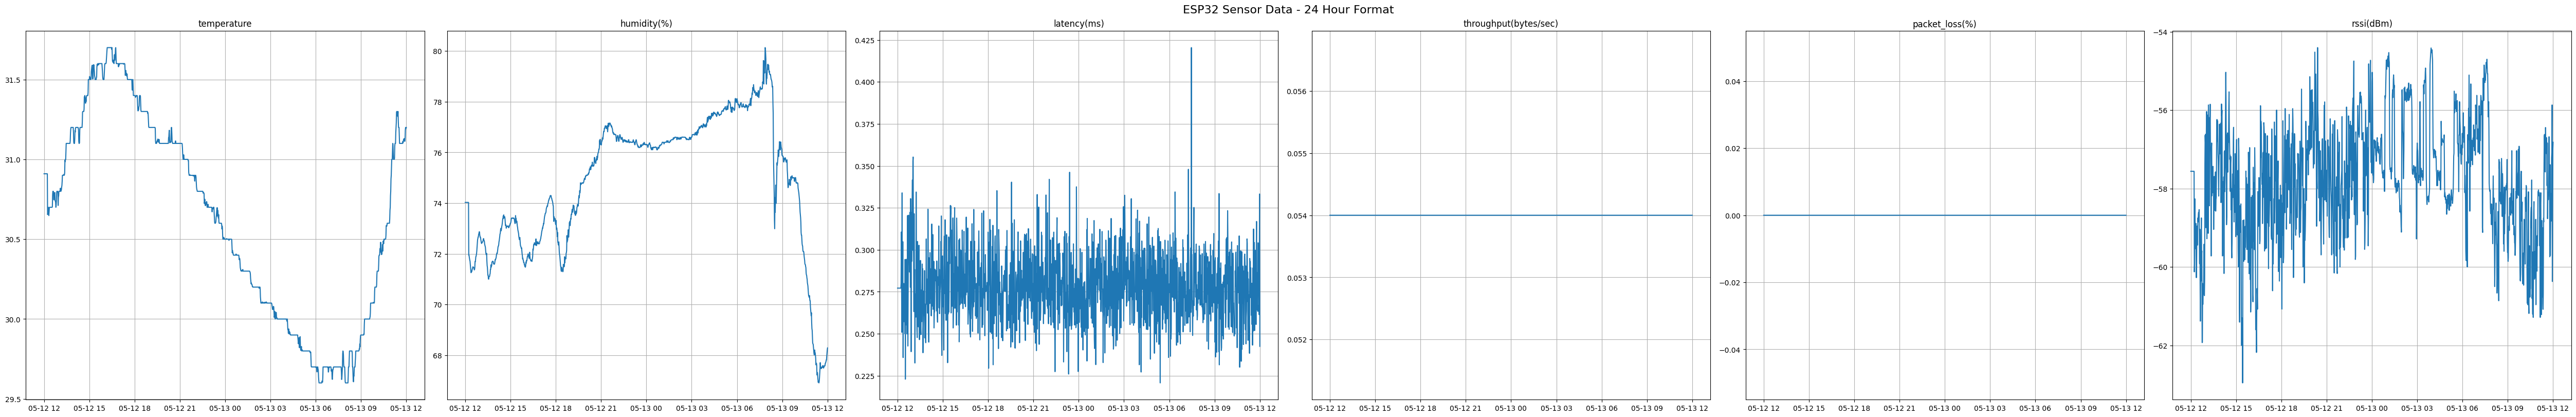

In [7]:
# Define num of rows and columns for the subplots
num_cols = 6
num_rows = int(np.ceil(len(df_one_day_format.columns) / num_cols))

# Create the figure and axes for the subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(50, 8), constrained_layout=True)

# Flatten the axes array for iteration
axes = axes.flatten()

# Plot each column in a separate subplot
for i, column in enumerate(df_one_day_format.columns):
  axes[i].plot(df_one_day_format[column])
  axes[i].set_title(column)
  axes[i].grid(True)

# Remove any unused subplots
for j in range(i + 1, len(axes)):
  fig.delaxes(axes[j])

# Set the overall title for the figure
fig.suptitle("ESP32 Sensor Data - 24 Hour Format", fontsize=16)
plt.show()